# MC Renormalization Group for 2d Ising Model

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

from functions import *

plt.rcParams.update({'font.size': 22})

In [23]:
# Load the samples
N = 540
dataPath = 'configs/'
print('Reading configurations from %s'%dataPath)
fVec = sorted(os.listdir(dataPath), key = getSimIdxPadded)
configsArr = [np.array(pd.read_csv(dataPath+c,header = None)) for c in fVec if 'N'+str(N) in c]
nsamples = len(configsArr)
print('Number of samples found:',nsamples)

mag = [np.mean(c) for c in configsArr]
magstd = [np.std(c) for c in configsArr]

Reading configurations from configs/
Number of samples found: 1000


In [24]:
# List of spin products to calculate
# Note: list the exact names of the functions to be called
evenEnergyTerms  = [nNbEnergy,nnNbEnergy,nnnNbEnergy] 
oddEnergyTerms = [externalFieldEnergy]
energyTerms = evenEnergyTerms + oddEnergyTerms
NEvenTerms = len(evenEnergyTerms)
NOddTerms = len(oddEnergyTerms)
NTerms = len(energyTerms)
print('\nSpin products terms to calculate:',[f.__name__ for f in energyTerms])


Spin products terms to calculate: ['nNbEnergy', 'nnNbEnergy', 'nnnNbEnergy', 'externalFieldEnergy']


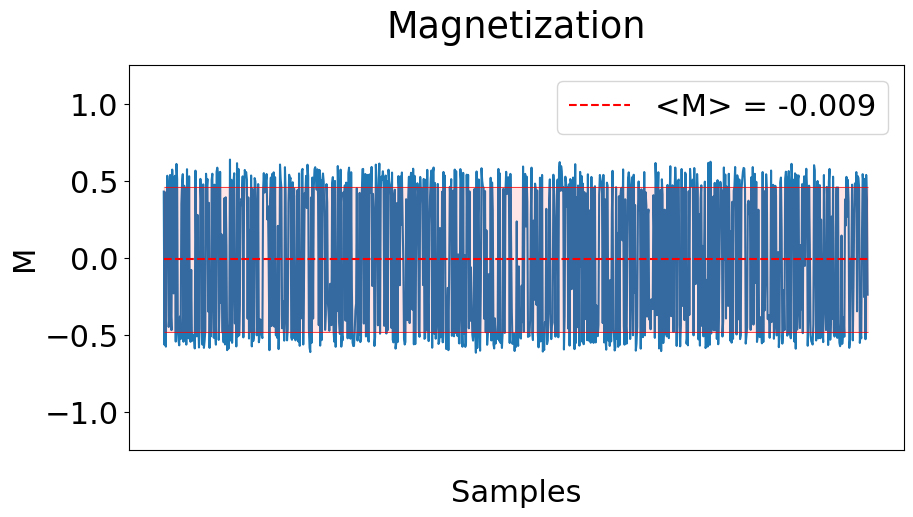

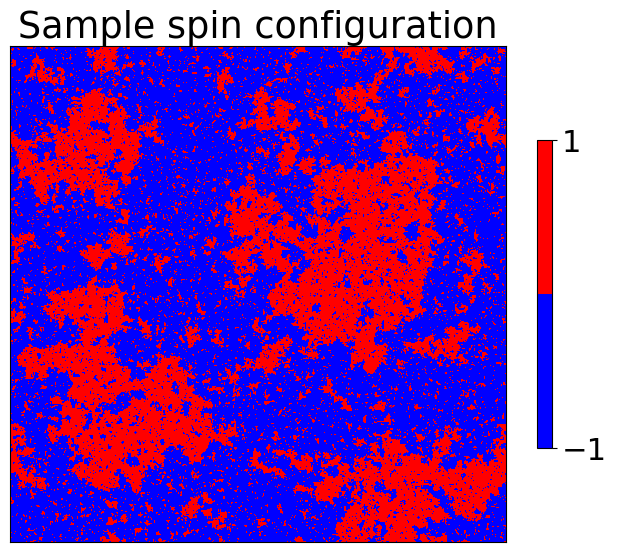

In [25]:
# Check that the samples are critical and view one of them
plt.figure(figsize=(10,5))
plt.plot(mag,zorder=1)
plt.title('Magnetization', pad=20)
plt.xticks([])
plt.ylabel('M')
plt.xlabel('Samples', labelpad=20)
plt.hlines(np.mean(mag), 0, nsamples, colors='r', linestyles='dashed',zorder=2,label='<M> = %.3f'%np.mean(mag))
plt.hlines([np.mean(mag)+np.std(mag),np.mean(mag)-np.std(mag)], 0, nsamples, linewidth=0.5, colors='r',zorder=2)
plt.fill_between(range(nsamples),np.mean(mag)-np.std(mag),np.mean(mag)+np.std(mag),color='r',alpha=0.1)
plt.legend(loc = 'upper right')
plt.ylim(-1.25,1.25)
plt.show()

ksample = nsamples-1
fig, ax = spinConfPlot(configsArr[ksample])
ax.set_title('Sample spin configuration')
plt.show()

Showing the configurations obtained by decimation for a sample


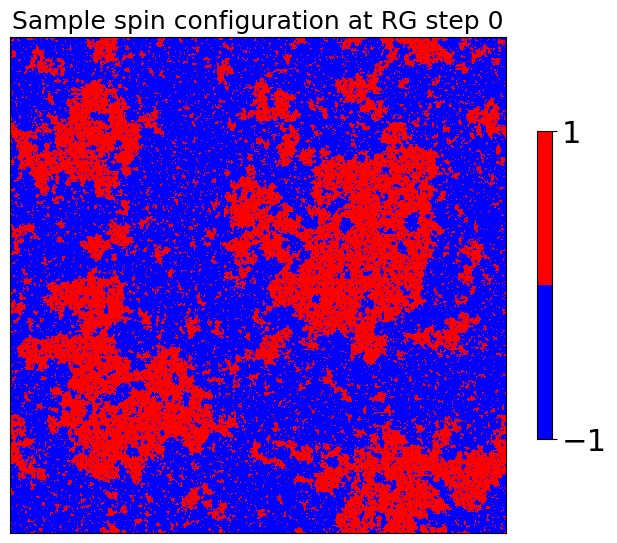

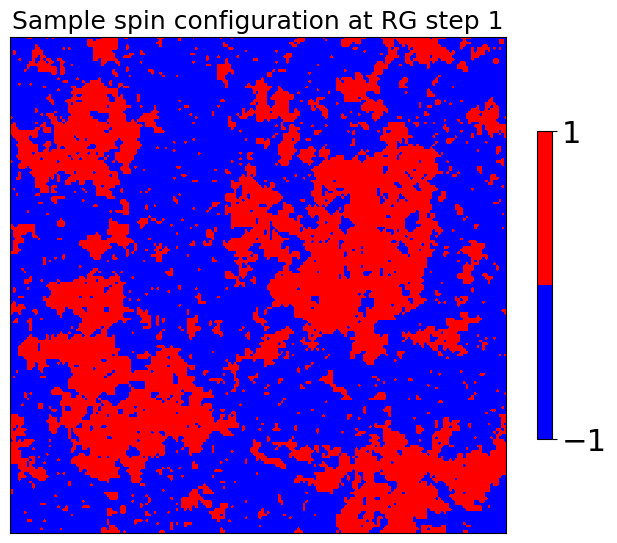

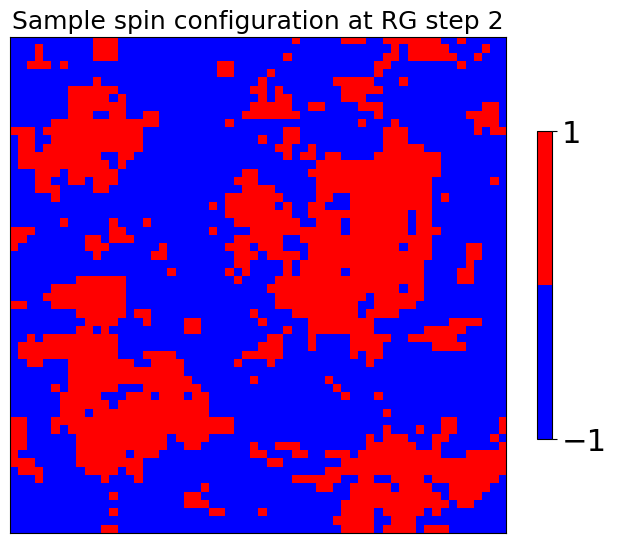

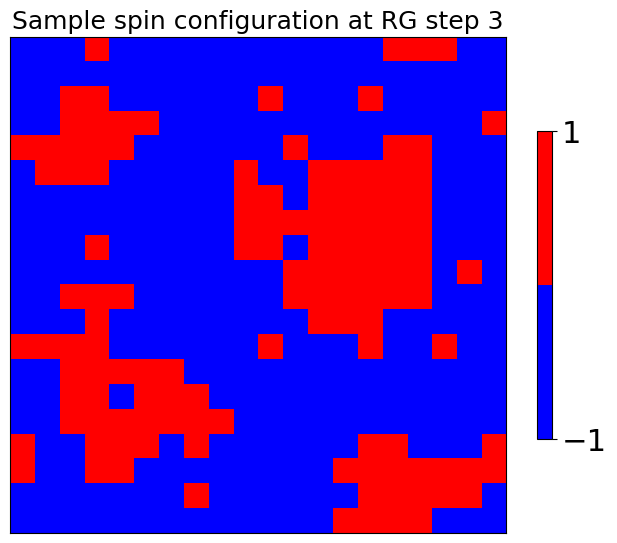

In [26]:
NRGsteps = 3 # number of RG steps

Ndec = 3 # side of the square of the block-spin considered during the RG decimation procedure; note that the scale factor is b = 3

print('Showing the configurations obtained by decimation for a sample')
config = configsArr[ksample]
for i in range(NRGsteps):
    fig, ax = spinConfPlot(config)
    ax.set_title('Sample spin configuration at RG step %d'%i,fontsize=18)
    plt.show()
    config = decimation(config,Ndec)
fig, ax = spinConfPlot(config)
ax.set_title('Sample spin configuration at RG step %d'%NRGsteps,fontsize=18)
plt.show()

In [27]:
# Create an empty array to save the energy terms
# 0th direction: terms for the same configuration at each level of coarse-graining
# 1st direction: different configurations at the same level of coarse-graining
# 2nd direction: different terms

print('Calculation of the spin products terms for all configurations obtained and for each RG step')

energyArr = np.zeros((NRGsteps+1,len(configsArr),NTerms))

for k in range(len(configsArr)):
    config = np.array(configsArr[k])
    for i in range(NRGsteps+1):    
        # Evaluate the spin products
        for j in range(NTerms):
            energyArr[i,k,j] = energyTerms[j](config)

        # Perform the RG decimation if we are not at the last step
        if i < NRGsteps:
            config = decimation(config,Ndec)

print('Done')

Calculation of the spin products terms for all configurations obtained and for each RG step
Done


In [28]:
print('Calculation of the correlation functions for the spin products terms')

CorrFunSyncArr = []
CorrFunAsyncArr = []

for i in range(NRGsteps+1): 
    # Take the energy terms of all configurations at the same RG step
    energyArrSliced = energyArr[i,:,:]

    # If at least one RG step has been performed, calculate the correlation functions
    if i >= 1:
        CorrFunSyncArr.append(mycov(energyArrSliced,energyArrSliced))
        CorrFunAsyncArr.append(mycov(energyArrSliced,energyArrSlicedPrec))

    energyArrSlicedPrec = energyArrSliced.copy()

print('Done')

Calculation of the correlation functions for the spin products terms
Done


RG step: 1
	Largest even eigenvalue:  2.786422411091736
	Largest odd eigenvalue:  7.707663895276436
RG step: 2
	Largest even eigenvalue:  3.059716874053758
	Largest odd eigenvalue:  7.830489522702925
RG step: 3
	Largest even eigenvalue:  (2.9518204923829225+0j)
	Largest odd eigenvalue:  7.846066301545116


/tmp/ipykernel_5848/3741930418.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  critExpData = pd.concat([critExpData, newDFRow], ignore_index=True)
/tmp/ipykernel_5848/3741930418.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nu[i] = np.log(Ndec)/np.log(maxEvenEig)


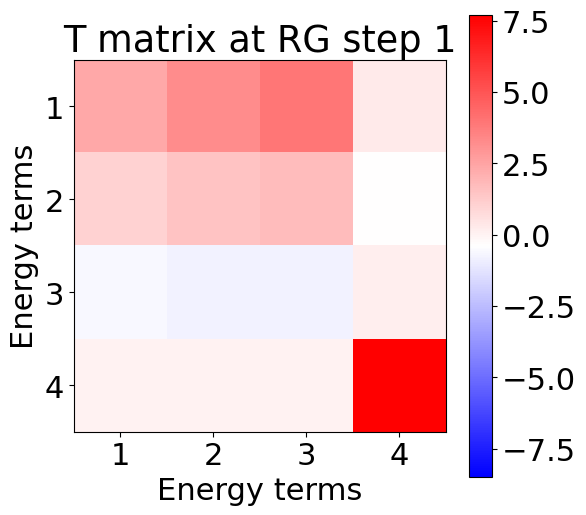

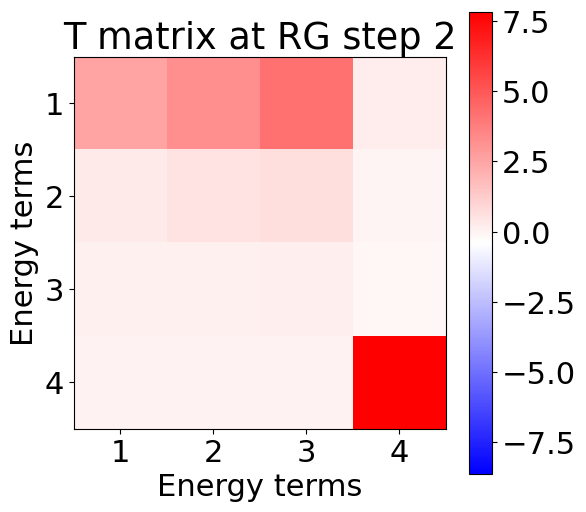

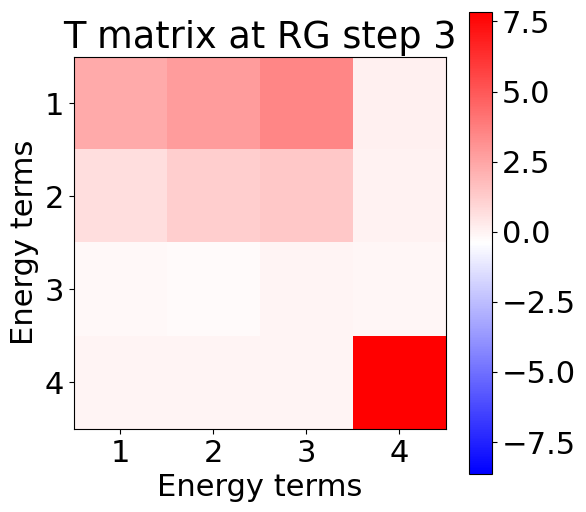

In [49]:
# Initialize the arrays for the critical exponents of the correlation functions
eta = np.zeros(NRGsteps)
nu = np.zeros(NRGsteps)
# Initialize a dataframe for storing the data
colnames = ['RG iteration','Max Even Eig','Max Odd Eig',r'$\alpha$',r'$\Delta\alpha$ (abs)',r'$\beta$',r'$\Delta\beta$ (\%)',r'$\gamma$',r'$\Delta\gamma$ (\%)',r'$\delta$',r'$\Delta\delta$ (\%)',r'$\eta$',r'$\Delta\eta$ (\%)',r'$\nu$',r'$\Delta\nu$ (\%)']
critExpData = pd.DataFrame(columns = colnames)

# Plot the RG transition matrices
for i in range(NRGsteps):
    print('RG step:',i+1)
    # Calculate the linearized RG transformation matrix T
    T = np.matmul(np.linalg.inv(CorrFunSyncArr[i]),CorrFunAsyncArr[i])
    plt.figure(figsize=(6,6))
    Tmax = np.max(np.abs(T))
    plt.imshow(T, cmap='bwr', vmin=Tmax, vmax=-Tmax)
    cbar = plt.colorbar()
    plt.title('T matrix at RG step %d'%(i+1))
    plt.xticks(np.arange(NTerms), np.arange(NTerms)+1)
    plt.yticks(np.arange(NTerms), np.arange(NTerms)+1)
    plt.xlabel('Energy terms')
    plt.ylabel('Energy terms')
    # Calculate the even/odd eigenvalues
    evenEigs = np.linalg.eigvals(T[:NEvenTerms,:NEvenTerms])
    maxEvenEig = np.max(evenEigs)
    oddEigs = np.linalg.eigvals(T[NEvenTerms:,NEvenTerms:])
    maxOddEig = np.max(oddEigs)
    print('\tLargest even eigenvalue: ',maxEvenEig)
    print('\tLargest odd eigenvalue: ',maxOddEig)
    eta[i] = 4 - 2*np.log(maxOddEig)/np.log(Ndec)
    nu[i] = np.log(Ndec)/np.log(maxEvenEig)
    newDFRow = pd.DataFrame({colnames[0]:i+1, colnames[1]:maxEvenEig, colnames[2]: maxOddEig, colnames[3]: 0, colnames[4]: 0,  colnames[5]: 0, colnames[6]: 0, colnames[7]: 0, colnames[8]: 0, colnames[9]: 0, colnames[10]: 0, colnames[11]: eta[i], colnames[12]: np.abs(eta[i]-0.25)*100/0.25,colnames[13]: nu[i], colnames[14]: np.abs(nu[i]-1)*100},index=[0])
    critExpData = pd.concat([critExpData, newDFRow], ignore_index=True)

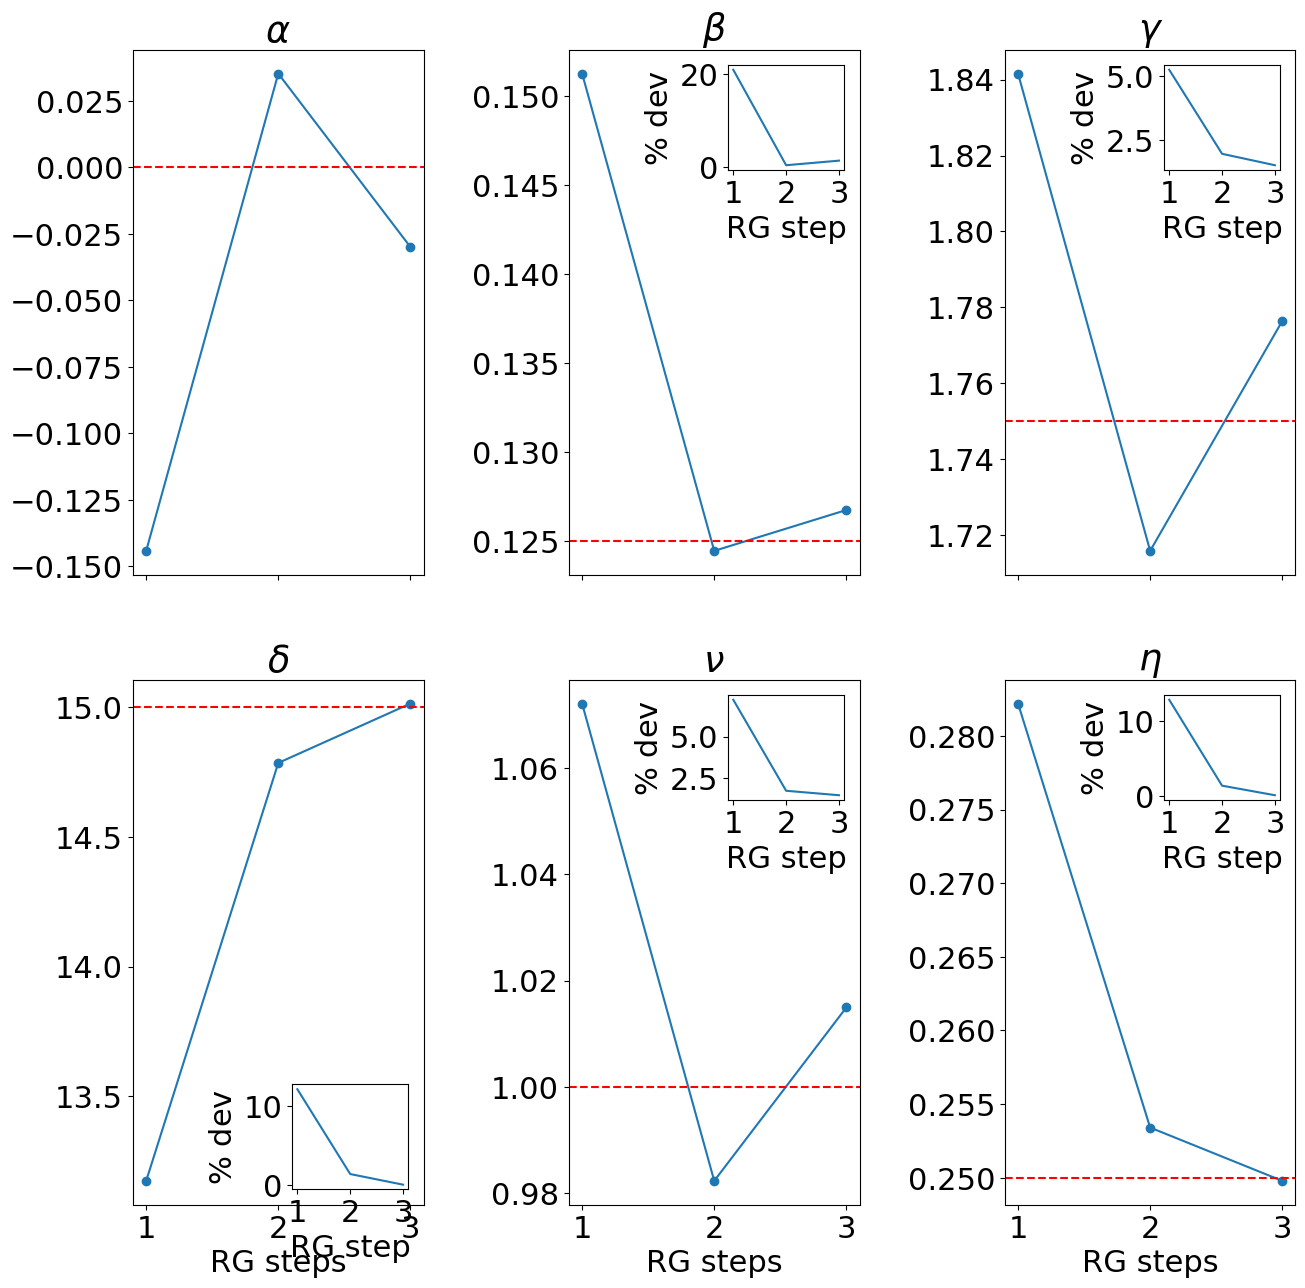

In [75]:
alpha = np.array([2*(1-n) for n in nu])
beta = np.array([n*e/2 for n,e in zip(nu,eta)])
gamma = np.array([n*(2-e) for n,e in zip(nu,eta)])
delta = np.array([(4-e)/e for e in eta])

critExpData[colnames[3]] = alpha
critExpData[colnames[4]] = np.abs(alpha)
critExpData[colnames[5]] = beta
critExpData[colnames[6]] = np.abs(beta-0.125)*100/0.125
critExpData[colnames[7]] = gamma
critExpData[colnames[8]] = np.abs(gamma-1.75)*100/1.75
critExpData[colnames[9]] = delta
critExpData[colnames[10]] = np.abs(delta-15)*100/15

fig, ax = plt.subplots(2,3,figsize=(15,15),sharex=True)
# Set all xticks to be integers
for i in range(2):
    for j in range(3):
        ax[i,j].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.subplots_adjust(wspace=0.5)
        
ax[0,0].plot(range(1,NRGsteps+1),alpha,marker='o')
ax[0,0].axhline(y=0, color='r', linestyle='--')
ax[0,0].set_title(r'$\alpha$')

ax[0,1].plot(range(1,NRGsteps+1),beta,marker='o')
ax[0,1].axhline(y=0.125, color='r', linestyle='--')
ax[0,1].set_title(r'$\beta$')
axins = inset_axes(ax[0,1], width="40%", height="20%", loc='upper right')
axins.plot(range(1,NRGsteps+1), critExpData[colnames[6]])
axins.set_xlabel('RG step')
axins.set_ylabel(r'$\%$ dev')

ax[0,2].plot(range(1,NRGsteps+1),gamma,marker='o')
ax[0,2].axhline(y=1.75, color='r', linestyle='--')
ax[0,2].set_title(r'$\gamma$')
axins = inset_axes(ax[0,2], width="40%", height="20%", loc='upper right')
axins.plot(range(1,NRGsteps+1), critExpData[colnames[8]])
axins.set_xlabel('RG step')
axins.set_ylabel(r'$\%$ dev')

ax[1,0].plot(range(1,NRGsteps+1),delta,marker='o')
ax[1,0].axhline(y=15, color='r', linestyle='--')
ax[1,0].set_title(r'$\delta$')
ax[1,0].set_xlabel('RG steps')
axins = inset_axes(ax[1,0], width="40%", height="20%", loc='lower right')
axins.plot(range(1,NRGsteps+1), critExpData[colnames[10]])
axins.set_xlabel('RG step')
axins.set_ylabel(r'$\%$ dev')

ax[1,1].plot(range(1,NRGsteps+1),nu,marker='o')
ax[1,1].axhline(y=1, color='r', linestyle='--')
ax[1,1].set_title(r'$\nu$')
ax[1,1].set_xlabel('RG steps')
axins = inset_axes(ax[1,1], width="40%", height="20%", loc='upper right')
axins.plot(range(1,NRGsteps+1), critExpData[colnames[14]])
axins.set_xlabel('RG step')
axins.set_ylabel(r'$\%$ dev')

ax[1,2].plot(range(1,NRGsteps+1),eta,marker='o')
ax[1,2].axhline(y=0.25, color='r', linestyle='--')
ax[1,2].set_title(r'$\eta$')
ax[1,2].set_xlabel('RG steps')
axins = inset_axes(ax[1,2], width="40%", height="20%", loc='upper right')
axins.plot(range(1,NRGsteps+1), critExpData[colnames[12]])
axins.set_xlabel('RG step')
axins.set_ylabel(r'$\%$ dev')

plt.show()

In [57]:
critExpData

,RG iteration,Max Even Eig,Max Odd Eig,$\alpha$,$\Delta\alpha$ (abs),$\beta$,$\Delta\beta$ (\%),$\gamma$,$\Delta\gamma$ (\%),$\delta$,$\Delta\delta$ (\%),$\eta$,$\Delta\eta$ (\%),$\nu$,$\Delta\nu$ (\%)
0,1,2.786422+0.000000j,7.707664,-0.144139,0.144139,0.151264,21.011485,1.841610,5.234871,13.174780,12.168134,0.282191,12.876533,1.072069,7.206947
1,2,3.059717+0.000000j,7.830490,0.035249,0.035249,0.124472,0.422596,1.715807,1.953881,14.784710,1.435265,0.253410,1.363913,0.982375,1.762470
2,3,2.951820+0.000000j,7.846066,-0.029915,0.029915,0.126764,1.411292,1.776387,1.507801,15.013323,0.088821,0.249792,0.083201,1.014957,1.495737
